# BlueSTARR vs Kirchir 2019
adapted from: /igvf/hlapp/viz/preds/Kircher-vs-BlueSTARR-preds.ipynb


In [30]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import gzip
import numpy as np
import duckdb
import polars as pl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import glob
from tqdm import tqdm

BlueSTARR parquets database 

In [32]:
blue_dir = '/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/parquets_K562_bluestarr'
in_dir = '/work/igvf-pm/K562/CRE-preds/processed-preds'
delta_dir_enh = '/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/parquets_K562_enh'
all_bluestarr = output_dir+'/all-bluestarr.txt'


In [ ]:
header = ['chrom', 'effect','pos','ref','alt']

with open(all_bluestarr, "w", encoding="utf-8") as outfile:  
    outfile.write("\t".join(header)+'\n')
    for i in tqdm(range(1, 1065)):
        with open(in_dir+'/pred'+str(i)+'.txt', "r", encoding="utf-8") as infile:
            for i, line in enumerate(infile):
                if i == 0: continue
                    
                line_parts = line.strip().split('\t')
                chrom = line_parts[0]
                effect = line_parts[3]
                pos = line_parts[4].split(':')[1]
                ref = line_parts[4].split(':')[2]
                alt = line_parts[4].split(':')[3]
                out_line = [chrom, effect, pos, ref, alt]
                outfile.write("\t".join(out_line) + "\n")
            

In [ ]:
chunks = pd.read_csv(all_bluestarr, sep='\t',
                   chunksize=10_000, low_memory=False)
for chunk in chunks:
    table = pa.Table.from_pandas(chunk)
    pq.write_to_dataset(
        table, 
        root_path=output_dir, 
        partition_cols=["chrom"],  # Partition by 'chrom' column
        compression="snappy" ,
        # existing_data_behavior="delete_matching" 
    )
        

In [3]:
bk =  pl.scan_csv('/hpc/group/igvf/db/blue_kircher.csv.gz')


In [5]:
delta_enh = duckdb.read_parquet(f"{delta_dir_enh}/**/*.parquet", hive_partitioning=True)
dbk = duckdb.sql(
    """
    SELECT DISTINCT d.ref AS delta_ref_allele, d.delta, bk.*
    FROM delta_enh d, bk 
    WHERE d.chrm = bk.chrom AND d.alt = bk.alt_allele AND d.posg-1 = bk.allele_pos
    """
).df()
dbk

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,delta_ref_allele,delta,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags
0,G,0.36,chr1,109274651,G,C,G,-0.011914,-0.08,0.329588,102
1,G,0.03,chr1,109274651,G,T,G,-0.003484,0.25,0.324233,6
2,A,-1.84,chr1,109274653,A,C,A,-0.008571,-0.05,0.331494,152
3,C,1.42,chr1,109274654,C,G,C,0.009533,-0.09,0.210022,157
4,G,1.53,chr1,109274656,G,A,G,-0.004786,0.12,0.000424,316
...,...,...,...,...,...,...,...,...,...,...,...
15815,T,0.34,chr8,127401184,T,C,T,-0.001666,-0.00,0.789616,454
15816,A,-0.08,chr8,127401384,A,C,A,0.023284,0.10,0.237965,18
15817,C,1.03,chr8,127401260,C,T,C,0.001078,-0.05,0.106445,142
15818,G,0.46,chr8,127401203,G,A,G,0.010981,0.01,0.694032,195


In [6]:
# sanity check
# ref_allele: Kirchir's ref, ref: Blue's ref
dbk.loc[(dbk['ref_allele'] != dbk['blue_ref_allele']) | (dbk['ref_allele'] != dbk['delta_ref_allele']) | (dbk['blue_ref_allele'] != dbk['delta_ref_allele']), ]

,delta_ref_allele,delta,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags


In [7]:
dbk.to_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_kirchir_delta.csv', index = False)

In [22]:
dbk = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_kirchir_delta.csv')
dbk.loc[(dbk['mpra_p_value']<1e-5) & (dbk['mpra_tags']>=10), 'label'] = 1
dbk.loc[(dbk['mpra_p_value']>0.1) & (dbk['mpra_tags']>=10) & (dbk['mpra_max_log2effect'].abs()<0.05), 'label'] = 0
dbk['abs_mpra_max_log2effect'] = dbk['mpra_max_log2effect'].abs()

In [23]:
dbk_TF_200 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['abs_mpra_max_log2effect'], ascending=False)[:200]
# dbk_TF_200 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['mpra_max_log2effect'], ascending=False)[:200]
dbk_TN_200 = dbk.loc[dbk['label'] == 0, ].sample(n=200, random_state=1)
dbk_top200 = pd.concat([dbk_TF_200, dbk_TN_200], ignore_index=True)
dbk_top200['label'].value_counts()

label
1.0    200
0.0    200
Name: count, dtype: int64

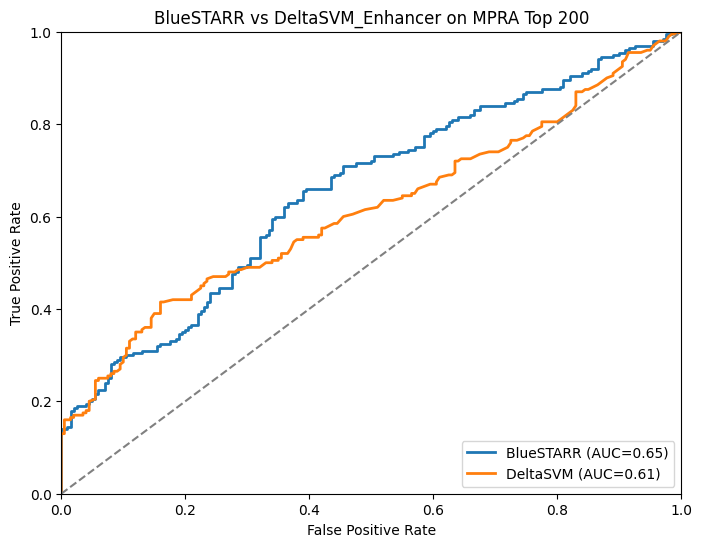

In [24]:
fpr_b, tpr_b, _ = roc_curve(dbk_top200['label'], dbk_top200['log2FC'].abs())
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(dbk_top200['label'], dbk_top200['delta'].abs())
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer on MPRA Top 200")
plt.legend(loc="lower right")

plt.show()

In [25]:
dbk_TF_500 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['abs_mpra_max_log2effect'], ascending=False)[:500]
# dbk_TF_500 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['mpra_max_log2effect'], ascending=False)[:500]
dbk_TN_500 = dbk.loc[dbk['label'] == 0, ].sample(n=500, random_state=42)
dbk_top500 = pd.concat([dbk_TF_500, dbk_TN_500], ignore_index=True)
dbk_top500['label'].value_counts()

label
1.0    500
0.0    500
Name: count, dtype: int64

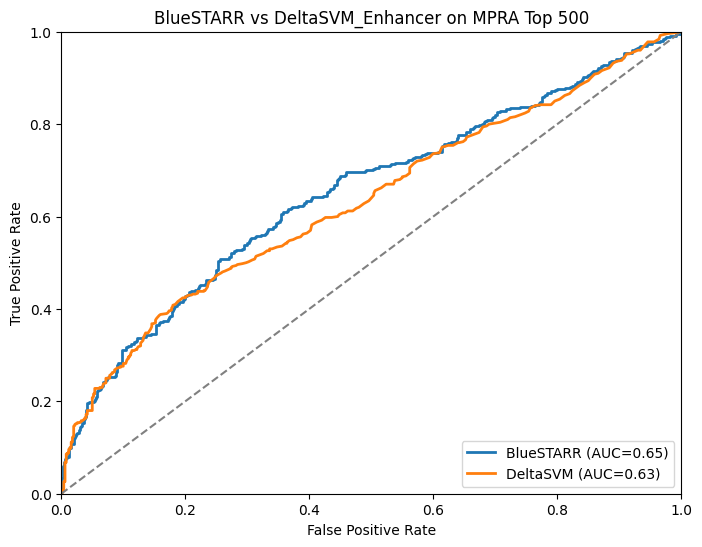

In [26]:
fpr_b, tpr_b, _ = roc_curve(dbk_top500['label'], dbk_top500['log2FC'].abs())
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(dbk_top500['label'], dbk_top500['delta'].abs())
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer on MPRA Top 500")
plt.legend(loc="lower right")

plt.show()

In [27]:
dbk_TF_1000 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['abs_mpra_max_log2effect'], ascending=False)[:1000]
# dbk_TF_1000 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['mpra_max_log2effect'], ascending=False)[:1000]
dbk_TN_1000 = dbk.loc[dbk['label'] == 0, ].sample(n=1000, random_state=42)
dbk_top1000 = pd.concat([dbk_TF_1000, dbk_TN_1000], ignore_index=True)
dbk_top1000['label'].value_counts()

label
1.0    1000
0.0    1000
Name: count, dtype: int64

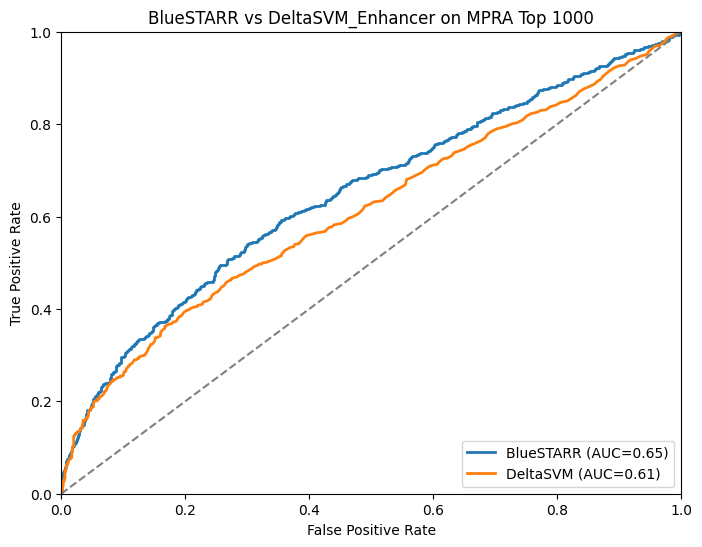

In [28]:
fpr_b, tpr_b, _ = roc_curve(dbk_top1000['label'], dbk_top1000['log2FC'].abs())
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(dbk_top1000['label'], dbk_top1000['delta'].abs())
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer on MPRA Top 1000")
plt.legend(loc="lower right")

plt.show()

In [35]:
blue = duckdb.read_parquet(f"{blue_dir}/**/*.parquet", hive_partitioning=True)
duplicated = duckdb.sql(
    """
    SELECT b.chrom, b.pos, b.ref, b.alt, ANY_VALUE(b.effect) AS effect
    FROM blue b
    GROUP BY b.chrom, b.pos, b.ref,b.alt
    HAVING COUNT(*)>1
    """
).df()
duplicated

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,chrom,pos,ref,alt,effect
